Part 1: A supervised learning approach to link-prediction (50%)
In the first part of this assignment you will develop a link-prediction algorithm based on the supervised learning methods you learned in this course. Link prediction can be framed as a classification problem, where an algorithm can be trained to predict the class of any possible link — existent (positive) or non-existent (negative). To tackle this problem you should follow some steps:

Feature engineering: First you should be able to import network data and define the features you believe are relevant to predict links in social networks. The data we will provide you consist of a social network where some links were removed. Each node will also be characterised by a categorical feature. Examples of important features might be the class that nodes belong to, or the number of common connections between nodes.
Defining a training, validation and test set: Once you have defined your feature space, you have to create your training, validation and test set. Your training set should be composed of positive examples (i.e., edges that exist in the network that was provided to you) and corresponding features. Your training set should also be composed of negative examples (i.e., edges that do not exist in the network provided). You will need to decide the ratio of positive and negative examples to include in your training set. You also have to decide about the split between training, validation and test set to train and select your best model. 
Model selection and validation: Once you have the required training and validation set, you have to select a model to be trained. You must use one of the methods discussed in the lectures (more complex models will not necessarily lead to higher performance, given the characteristics of the data we will provide you).
Application and test: Once you trained and validated your model, your solution should be able to decide if a (missing) link exists or not in a network. You will be welcome to submit your guesses to a Kaggle competition (details below). 
Note that we provide an auxiliary notebook (and auxiliary files) that can greatly help you in the previous steps. 


 

Data
The base dataset to use consists of a (synthetic) social network with 1500 nodes and 7333 links. This network was generated by removing ~10% of the links of an original network (only 6600 links are visible). Your task is to accurately guess whether a link given as an input belongs (or not) to the original network. All needed data can be found in the following file.

Network data: Each node is numbered from 0 to N-1, where N is the number of nodes in the network. The network structure is provided as a list of edges (edges_train.edgelist). In this file, each line corresponds to an edge (or link): int1,int2 where int1 and int2 correspond to the identification of each node connected by the edge. The network is assumed to be undirected (i.e., if a connection between nodes 1 and 2 exists in the file, the connection 2 to 1 is also assumed to exist).
Node data: Each node is characterised by a categorical feature that can take 5 possible values ['x', 'd', 'y', 'f', 'm', 'l']. These might constitute a sensitive attribute (e.g., political affiliation, personal preferences, demographic data...). The feature of each node is provided in a .csv file (attributes.csv). In this file, each line corresponds to a node and the value in a given line corresponds to the feature of the corresponding node. 
Final test data: The ultimate goal of your algorithm is to determine if a link exists or not in the original network. In file solutionInput.csv you are provided a list of links. You should be able to output, for each link, a prediction: 1 if you believe the links exists in the original network; 0 if you believe the links does not exist in the original network. solutionInput.csv contains a total of 1466 links: 733 exist in the original network (positive examples); 733 do not exist in the original network (negative examples). Your ultimate goal is to develop an algorithm that achieves high accuracy in this test data. In Lab5 you will already produce an example of output that your (assignment 2) program should provide (example of Lab 5 output here Download here).

In [2]:
# import relevant libraries
import itertools
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# read in associated files
attri = pd.read_csv('attributes.csv', sep=',', index_col="ID")
sol_inp = pd.read_csv('solutionInput.csv', sep=',', index_col="ID")

In [4]:
#view attributes.csv
attri.head()

,attribute
ID,
0,l
1,x
2,x
3,x
4,x


In [5]:
#view solutionInput.csv
sol_inp.head()

,int1,int2
ID,,
0,56,396
1,760,853
2,340,1137
3,597,771
4,1355,1410


In [6]:
# import edgelist
edge_list = nx.read_edgelist("edges_train.edgelist", data=False, nodetype = int, delimiter=',') # import

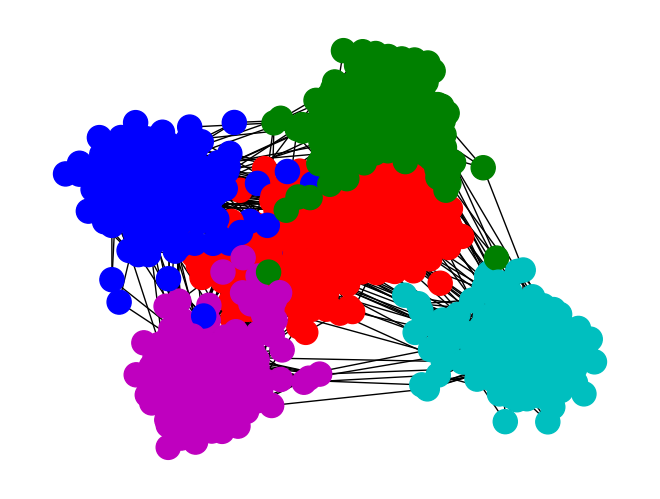

In [7]:
#### COMMUNITY DETECTION ####

#the function will return a partition of nodes
c = list(greedy_modularity_communities(edge_list, resolution=0.8))

# Create a color map for each node based on its community
color_map = []

# Assign each community a unique color
colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple'])

# Create a dictionary to store which node belongs to which community
c_color = {}
for community, color in zip(c, colors):
    for node in community:
        c_color[node] = color

# Apply the color to each node based on its community
for node in edge_list.nodes:
    color_map.append(c_color[node])

# draw node network
nx.draw(edge_list, node_color=color_map)

1. Common Neighbors
This metric counts how many neighbors two nodes have in common. The idea is that nodes that share more common neighbors are more likely to form a link.

2. Jaccard Coefficient
The Jaccard Coefficient measures the similarity between two nodes based on the proportion of shared neighbors to the total number of neighbors between the two nodes.

3. Adamic-Adar Index
This measure gives more weight to common neighbors who themselves have fewer neighbors. The intuition is that a shared connection to a node with fewer connections is a stronger indicator of a future link.

4. Resource Allocation Index
This is similar to Adamic-Adar, but it directly sums the reciprocal of the degree of the common neighbors. It quantifies how much "resource" a node can allocate through shared neighbors.

5. Katz Centrality
Katz centrality is a generalization of the eigenvector centrality, giving higher scores to nodes that are connected through longer paths.

6. Clustering Coefficient
The clustering coefficient measures how connected a node's neighbors are. The intuition is that nodes in tightly-knit communities are more likely to form links.

7. Shortest Path Length
The shortest path length between two nodes can be used as a feature. Nodes that are only a short distance apart are more likely to connect.


In [9]:
#### LINK PREDICTION ###

# Generate features from edge endpoints
# Input: getFeature(graph, node_i, node_j)
def getFeature(G, i, j):
    """
    Function to extract features for link prediction between two nodes (i, j).
    
    Parameters:
    G (Graph): NetworkX graph object
    i, j (nodes): Nodes for which features are calculated
    
    Returns:
    features (dict): A dictionary containing the calculated features
    """
    
    # Preferential Attachment
    pref_attach = list(nx.preferential_attachment(G, [(i, j)]))[0][2]
    
    # Common Neighbors
    common_neighbors = len(list(nx.common_neighbors(G, i, j)))
    
    # Jaccard Coefficient
    jaccard_coeff = list(nx.jaccard_coefficient(G, [(i, j)]))[0][2]
    
    # Adamic-Adar Index
    #adamic_adar = list(nx.adamic_adar_index(G, [(i, j)]))[0][2]
    
    # Resource Allocation Index
    #resource_alloc = list(nx.resource_allocation_index(G, [(i, j)]))[0][2]
    
    # Shortest Path (Handle exception if no path exists)
    #try:
        #shortest_path = nx.shortest_path_length(G, source=i, target=j)
    #except nx.NetworkXNoPath:
        #shortest_path = float('inf')  # Infinite if no path exists
    
    # Return a dictionary with the features
    features = {
        'preferential_attachment': pref_attach,
        'common_neighbors': common_neighbors,
        'jaccard_coefficient': jaccard_coeff,
        #'adamic_adar': adamic_adar,
        #'resource_allocation': resource_alloc,
        #'shortest_path': shortest_path
    }
    
    return features

In [10]:
# call getFeature function on our edgelist
for index,row in sol_inp.iterrows():
    features = getFeature(edge_list,row['int1'],row['int2'])
    print(features)

{'preferential_attachment': 30, 'common_neighbors': 0, 'jaccard_coefficient': 0.0}
{'preferential_attachment': 222, 'common_neighbors': 2, 'jaccard_coefficient': 0.04878048780487805}
{'preferential_attachment': 49, 'common_neighbors': 0, 'jaccard_coefficient': 0.0}
{'preferential_attachment': 105, 'common_neighbors': 0, 'jaccard_coefficient': 0.0}
{'preferential_attachment': 35, 'common_neighbors': 0, 'jaccard_coefficient': 0.0}
{'preferential_attachment': 50, 'common_neighbors': 0, 'jaccard_coefficient': 0.0}
{'preferential_attachment': 200, 'common_neighbors': 2, 'jaccard_coefficient': 0.06451612903225806}
{'preferential_attachment': 2052, 'common_neighbors': 10, 'jaccard_coefficient': 0.12195121951219512}
{'preferential_attachment': 30, 'common_neighbors': 0, 'jaccard_coefficient': 0.0}
{'preferential_attachment': 432, 'common_neighbors': 1, 'jaccard_coefficient': 0.02127659574468085}
{'preferential_attachment': 21, 'common_neighbors': 1, 'jaccard_coefficient': 0.1111111111111111}
{

Next Steps:
Feature Scaling: If you want to use these features in a machine learning model, you may need to normalize or standardize the features so that they are on a comparable scale.

Modeling: Once you’ve extracted these features, you can train a machine learning model (like Logistic Regression, Random Forest, etc.) to predict whether a link will occur between two nodes.

Accuracy: 0.8517676767676767
AUC Score: 0.7501203739632082
Precision Score: 0.7856620336503292


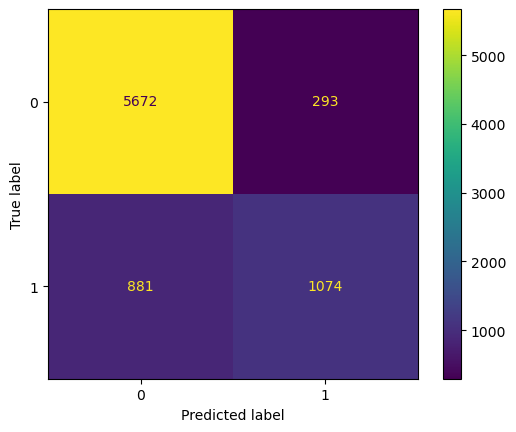

In [12]:
# Step 1: Create a list of all node pairs (both positive and negative pairs)
def get_node_pairs(G):
    positive_pairs = list(G.edges())  # These are pairs that are actually connected (positive)

    # Generate random node pairs that are not connected (negative)
    all_nodes = list(G.nodes())
    negative_pairs = []
    while len(negative_pairs) < len(positive_pairs)* 3: # Common practice is to use a 1:1 or 1:2 ratio of positive to negative examples
        u, v = np.random.choice(all_nodes, 2, replace=False)
        if not G.has_edge(u, v) and (u, v) not in negative_pairs and (v, u) not in negative_pairs:
            negative_pairs.append((u, v))
            
    return positive_pairs, negative_pairs

# Step 2: Extract features for each pair (both positive and negative)
def extract_features(G, pairs):
    features = []
    for u, v in pairs:
        feature_dict = getFeature(G, u, v)  # Get features for each pair
        feature_vector = list(feature_dict.values())  # Convert the feature dict to a list of values
        features.append(feature_vector)
    return features

# Step 3: Prepare the labels
def prepare_labels(positive_pairs, negative_pairs):
    y_positive = [1] * len(positive_pairs)  # Label for positive pairs (connected)
    y_negative = [0] * len(negative_pairs)  # Label for negative pairs (not connected)
    return y_positive + y_negative

# Step 4: Train the Logistic Regression Model
def train_model(X_train, y_train):

    # Parameter grids for each model
    param_grid = [
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}]  # Logistic Regression
    
    model = LogisticRegression()
    grid = GridSearchCV(model, param_grid, cv=10)
    grid.fit(X_train, y_train);
    return grid

# Step 5: Evaluate the model
def evaluate_model(grid, X_test, y_test):
    y_pred = grid.best_estimator_.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"AUC Score: {auc}")
    print(f"Precision Score: {precision}")

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.show()


# Get positive and negative node pairs
positive_pairs, negative_pairs = get_node_pairs(edge_list)
    
# Extract features for both positive and negative pairs
X_positive = extract_features(edge_list, positive_pairs)
X_negative = extract_features(edge_list, negative_pairs)

# Combine features and create the feature matrix
X_train = X_positive + X_negative
y_train = prepare_labels(positive_pairs,negative_pairs)  # Create labels for positive and negative pairs

# Split data into training and testing sets to evaluate model performance
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the model
model = train_model(X_train, y_train)

evaluate_model(model, X_test, y_test)

In [13]:
test_sol_inp = list(zip(sol_inp['int1'], sol_inp['int2']))  # Get node pairs from CSV

# Extract features for these test pairs
sol_test = extract_features(edge_list, test_sol_inp)

# Predict links for the test pairs
y_pred = model.predict(sol_test)

# Output solution
pd.DataFrame(y_pred).to_csv('solutionInput_predictions.csv', index=True, header=["prediction"], index_label="ID")